In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from PIL import Image
import numpy as np
import torch
from torchvision import transforms
import torchvision
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder


from tqdm import tqdm

In [3]:
data_dir = './xray_dataset/'
# convert all input images to square tensors
# this step is probably ruining the data
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.Grayscale(num_output_channels=1),
    # normalize the data
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])


In [4]:
# Load training data
train_data = ImageFolder(root=data_dir + 'train', transform=transform)

# Load validation data
val_data = ImageFolder(root=data_dir + 'val', transform=transform)
val_loader = DataLoader(val_data, batch_size=32, shuffle=True)

# Load test data
test_data = ImageFolder(root=data_dir + 'test', transform=transform)
test_loader = DataLoader(test_data, batch_size=32, shuffle=True)

### Data loaders

In [5]:
# from torch.utils.data import DataLoader, TensorDataset

# # Create TensorDataset objects
# train_dataset = TensorDataset(train_data, train_labels)
# val_dataset = TensorDataset(val_data, val_labels)
# test_dataset = TensorDataset(test_data, test_labels)

# # Create DataLoader objects
batch_size = 32
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


### Let's do some displaying

### Let's do some training

In [6]:
from torch.utils.data import DataLoader, WeightedRandomSampler

# Calculate class weights
class_counts = [0] * len(train_data.classes)
print(class_counts)
labels_ = [label for _, label in tqdm(train_data)]
for label in tqdm(labels_):
    class_counts[label] += 1
class_weights = [1.0 / count for count in class_counts]
sample_weights = [class_weights[label] for label in labels_]


# Create weighted sampler and data loader
sampler = WeightedRandomSampler(sample_weights, len(sample_weights))
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)

[0, 0]


100%|██████████| 5216/5216 [00:00<00:00, 5059548.95it/s]


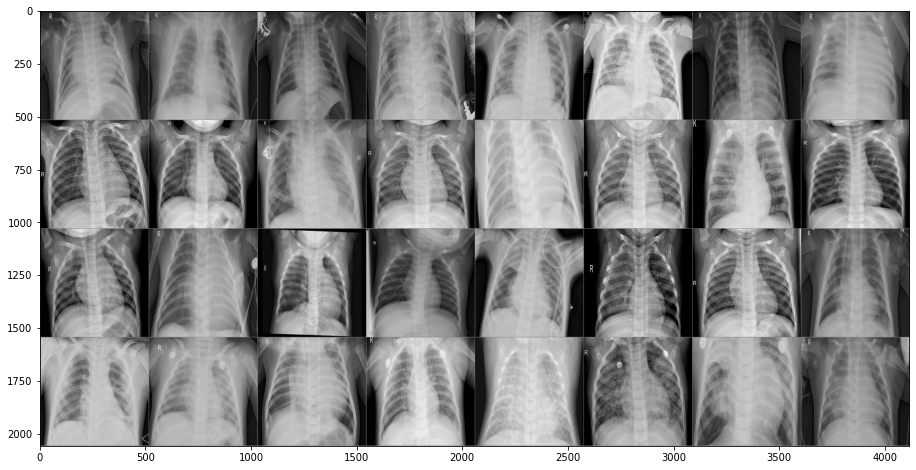

1 1 1 1 1 1 1 1 0 0 1 0 1 0 1 0 0 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1


In [10]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(16, 8))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.savefig('test.pdf')
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{labels[j]}' for j in range(batch_size)))


In [11]:
import torch.optim as optim
from CNN import *


net = CNN()
device = torch.device("mps")
net.to(device)

criterion = nn.CrossEntropyLoss(weight=torch.tensor(class_weights).to(device))
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


In [12]:
EPOCHS = 10
PRINT_EVERY = 40

for epoch in range(EPOCHS):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # move inputs and labels to MPS device
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % PRINT_EVERY == PRINT_EVERY - 1:
            # Calculate validation set loss and accuracy
            val_loss = 0.0
            val_total = 0
            val_correct = 0
            with torch.no_grad():
                for val_data in val_loader:
                    val_inputs, val_labels = val_data
                    val_inputs = val_inputs.to(device)
                    val_labels = val_labels.to(device)
                    val_outputs = net(val_inputs)
                    val_loss += criterion(val_outputs, val_labels).item()
                    _, val_predicted = torch.max(val_outputs.data, 1)
                    val_total += val_labels.size(0)
                    val_correct += (val_predicted == val_labels).sum().item()
            val_loss /= len(val_loader)
            val_acc = 100 * val_correct / val_total

            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / PRINT_EVERY:.3f}, '
                  f'val_loss: {val_loss:.3f}, val_acc: {val_acc:.2f}%')
            running_loss = 0.0

    # Calculate test set loss and accuracy
    test_loss = 0.0
    test_total = 0
    test_correct = 0
    with torch.no_grad():
        for test_data in test_loader:
            test_inputs, test_labels = test_data
            test_inputs = test_inputs.to(device)
            test_labels = test_labels.to(device)
            test_outputs = net(test_inputs)
            test_loss += criterion(test_outputs, test_labels).item()
            _, test_predicted = torch.max(test_outputs.data, 1)
            test_total += test_labels.size(0)
            test_correct += (test_predicted == test_labels).sum().item()
    test_loss /= len(test_loader)
    test_acc = 100 * test_correct / test_total

    print(f'Test set loss for EPOCH {epoch}: {test_loss:.3f}, test_acc: {test_acc:.2f}%')


print('Finished Training')

[1,    40] loss: 0.280, val_loss: 0.148, val_acc: 93.75%
[1,    80] loss: 0.115, val_loss: 0.135, val_acc: 87.50%
[1,   120] loss: 0.178, val_loss: 0.239, val_acc: 93.75%
[1,   160] loss: 0.079, val_loss: 0.112, val_acc: 93.75%


In [7]:
# save the model
MODEL_PATH = './xray_net.pth'
torch.save(net.state_dict(), MODEL_PATH)


In [ ]:
print(f'Test set loss: {test_loss:.3f}, test_acc: {test_acc:.2f}%')

Test set loss: 1.312, test_acc: 69.23%


## Q3

In [59]:
# def integrated_gradients(input_image, model, target_class_idx, baseline=None, num_steps=50):
#     if baseline is None:
#         baseline = torch.zeros_like(input_image)

#     # interpolate between the baseline and the input image
#     interpolated_images = []
#     for step in range(num_steps + 1):
#         alpha = step / num_steps
#         interpolated_image = baseline + alpha * (input_image - baseline)
#         interpolated_images.append(interpolated_image[0].requires_grad_())

#     stacked_interpolated_images = torch.stack(
#         interpolated_images).requires_grad_()
#     print(stacked_interpolated_images.shape)
#     # compute the gradients of the output with respect to the interpolated images
#     output = model(stacked_interpolated_images)
#     target_output = output[:, target_class_idx].mean()
#     gradients = torch.autograd.grad(target_output, interpolated_images)[0]

#     # compute the integrated gradients
#     integrated_gradients = torch.mean(gradients, axis=0) * (input_image - baseline)

#     return integrated_gradients


In [10]:
MODEL_PATH = './xray_net.pth'


In [30]:
import torch
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

from captum.attr import IntegratedGradients
from PIL import Image

# Move the model and test data to the GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)
model.load_state_dict(torch.load(MODEL_PATH))
test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=1, shuffle=False, num_workers=1, pin_memory=True)

# Define the Integrated Gradients explainer
ig = IntegratedGradients(model.to(device))

# Define a helper function to display the attribution map on the original image


def visualize_attribution(original_image, attribution_map):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))
    ax1.imshow(original_image)
    ax1.axis('off')
    ax2.imshow(attribution_map, cmap='gray')
    ax2.axis('off')
    plt.show()


# Generate attribution maps for 5 healthy and 5 pneumonia test samples
healthy_count = 0
pneumonia_count = 0
for images, labels in test_loader:
    # Skip samples until we have 5 of each class
    if healthy_count == 5 and pneumonia_count == 5:
        break

    if labels == 0 and healthy_count == 5:
        print('Skipping healthy sample')
        continue

    if labels == 1 and pneumonia_count == 5:
        print('Skipping unhealthy sample')
        continue

    # Move images and labels to the GPU
    images = images.to(device)
    labels = labels.to(device)

    # Generate an attribution map for the current sample
    images.requires_grad = True
    attribution = ig.attribute(images, target=labels)
    print(attribution.shape, images.shape)
    
    attribution_map = np.transpose(
        attribution.squeeze().cpu().detach().numpy())
    # break

    print(attribution_map)
    # normalize attribution map
    attribution_map = (attribution_map - np.min(attribution_map)) / \
        (np.max(attribution_map) - np.min(attribution_map)) * 255
    
    print(attribution_map)

    break

    # Display the attribution map on the original image
    if labels == 0 and healthy_count < 5:
        print('Healthy sample:', healthy_count+1)
        visualize_attribution(np.transpose(
            images.squeeze().cpu().detach().numpy()), attribution_map)
        healthy_count += 1
    elif labels == 1 and pneumonia_count < 5:
        print('Pneumonia sample:', pneumonia_count+1)
        visualize_attribution(np.transpose(
            images.squeeze().cpu().detach().numpy()), attribution_map)
        pneumonia_count += 1


torch.Size([1, 1, 512, 512]) torch.Size([1, 1, 512, 512])
[[-0.01348836  0.00248114  0.00015124 ...  0.00317048 -0.00600161
   0.00186659]
 [ 0.00537192  0.01932956 -0.00400913 ...  0.00660614 -0.00721443
   0.00407157]
 [ 0.03621807 -0.01790782 -0.00505432 ...  0.01299147 -0.00905937
  -0.00609722]
 ...
 [ 0.01513035 -0.00764695  0.00277968 ...  0.00452965 -0.01082393
  -0.01476514]
 [-0.00594885 -0.00175571 -0.01600723 ...  0.00925791  0.00925871
  -0.00455218]
 [ 0.00966524 -0.01925733 -0.00314637 ... -0.00017238 -0.00638282
  -0.00628585]]
[[ 84.68973669 104.86329625 101.92004264 ... 105.73410977  94.14741354
  104.08696845]
 [108.5150891  126.14716201  96.6644262  ... 110.07422225  92.61531113
  106.8724162 ]
 [147.48167182  79.10682013  95.34408209 ... 118.14054052  90.28468031
   94.02662914]
 ...
 [120.84249362  92.06892526 105.24042496 ... 107.45108716  88.05558402
   83.07683324]
 [ 94.2140583   99.51106602  81.5077503  ... 113.42408949 113.42509827
   95.97841004]
 [113.9386

In [24]:
# np.transpose(
images.squeeze().cpu().detach().numpy().shape


(1, 1, 512, 512)

In [ ]:
# # load the trained model and the test dataset
# model = CNN()
# model.load_state_dict(torch.load(MODEL_PATH))

# # define the target class indices
# healthy_idx = test_data.class_to_idx['NORMAL']
# disease_idx = test_data.class_to_idx['PNEUMONIA']

# one_test_loader = test_loader = DataLoader(test_data, batch_size=1)

# # # compute the attribution maps for five healthy and five disease test samples
# num_samples = 5
# for i, (image, label) in enumerate(one_test_loader):
#     image = image.to(device)
#     if label == healthy_idx and num_samples > 0:
#         attribution_map = integrated_gradients(model, image, healthy_idx, 0)
#         num_samples -= 1
#     elif label == disease_idx and num_samples > 0:
#         attribution_map = integrated_gradients(model, image, disease_idx, )
#         num_samples -= 1
#     else:
#         continue